# Данные

In [0]:
from string import punctuation
import re
punctuation = punctuation + '«»—…“”*№–'
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from statistics import mean 
import collections
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC

In [2]:
import pandas as pd
df = pd.read_csv('vk_texts_with_sources.csv', usecols = ['text', 'source'])
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


# Домашнее задание

В этом домашнем задании вы будете решать задачу тематической классификации. Даны тексты, опубликованные в нескольких пабликах VK.com, посвященных государственным и муниципальным службам. Формально задача заключается в том, чтобы по тексту ($d$) определить в каком паблике он опубликован, то есть, к какому классу $c$ он принадлежит. 

## Задание 1 [1 балл]. Описательные статистики
Посчитайте:
* количество текстов и количество классов
* количество слов (без лемматизации и с лемматизацией) в коллекции
* среднюю длину текста в словах и символах
* найдите 5 самых частых существительных в текстах каждого паблика 

*Рекомендуем использовать pandas для расчета описательных статистик.*

In [3]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print('Количество текстов:',len(df.text))
print('Количество классов:',len(df.source.unique()))

Количество текстов: 11526
Количество классов: 4


In [4]:
print("Средняя длина текста в символах:",mean([len(x) for x in df.text]))

Средняя длина текста в символах: 690.7630574353635


In [0]:
def remove_digits(text):
    words = [word.lower().strip(punctuation) for word in text.split()]
    words = [word for word in words if word not in stopwords.words('russian') and word != ""]
    return words

In [0]:
def preprocess_text(text):
    text = text.str.replace("<br>",'')
    text = text.apply(lambda x: remove_digits(x))
    return text

In [0]:
def lemmatize_text(text):
    lemmatized_text = [morph.parse(word)[0].normal_form for word in text]
    return lemmatized_text

In [8]:
import numpy as np
text = df.text.str.replace("<br>",'')
word_lists = [[w.strip(punctuation) for w in text.split() if w.strip(punctuation) and w != ""] for text in text]
avg_len = np.mean([len(text) for text in word_lists]) #среднее число слов в тексте
print("Среднее число слов в тексте:",avg_len)

Среднее число слов в тексте: 83.35953496442825


In [0]:
df.text = preprocess_text(df.text) ## предобработаем текст и разобьем его на слова

In [0]:
df['lemmas'] = df.text.apply(lambda x: lemmatize_text(x)) ##сделаем отдельную колонку с лемматизированными словами

In [11]:
unique_lemmatized_words = set()
for word in df.lemmas:
    unique_lemmatized_words.update(word)
print("Количество уникальных слов в лемматизированном тексте:",len(unique_lemmatized_words))

Количество уникальных слов в лемматизированном тексте: 48169


In [12]:
unique_words = set()
for word in df.text:
    unique_words.update(word)
print("Количество уникальных слов:",len(unique_words))

Количество уникальных слов: 93267


__Найдем 5 самых частотных существительных по каждому классу__

In [13]:
most_frequent = {} 
for source in df['source'].unique(): 
    arr = [] 
    for text in df[df['source'] == source]['lemmas']: 
        for word in text: 
            w = morph.parse(word)[0] 
            if w.tag.POS == 'NOUN': 
                arr.append(word) 

    count = collections.Counter(arr) 
    most_frequent[source] = count.most_common(1)[0][0] 
    print(source,count.most_common(5)) 
    print()

mil [('военный', 2029), ('минобороны', 1354), ('россия', 1289), ('год', 1273), ('оборона', 914)]

mchsgov [('мчс', 3489), ('россия', 1598), ('мчсроссия', 1218), ('спасатель', 613), ('год', 508)]

russianpost [('почта', 3143), ('россия', 2585), ('год', 2075), ('отделение', 1583), ('письмо', 1452)]

mospolice [('полиция', 5827), ('год', 5212), ('москва', 4160), ('мвд', 4154), ('россия', 3976)]



In [0]:
df['source_text'] = df['text'].apply(lambda x: ' '.join(x)) ## сделаем отдельные колонки для предложений предобработанных
df['lemmas_joined'] = df['lemmas'].apply(lambda x: ' '.join(x)) ## то же самое с лемматизированными словами

In [15]:
df = shuffle(df) ## перемешаем данные, чтобы избежать случаев с какой-то упорядоченностью данных

train, test = train_test_split(df, test_size=0.2) # разобьем данные на тренировочную и тестовую выборки: 0.8 к 0.2
train.head()

,text,source,lemmas,source_text,lemmas_joined
715,"[инженерные, подразделения, южного, военного, ...",mil,"[инженерный, подразделение, южный, военный, ок...",инженерные подразделения южного военного округ...,инженерный подразделение южный военный округа ...
8059,"[десятку, самых, дорогих, марок, мира, входит,...",russianpost,"[десятка, самый, дорогой, марка, мир, входить,...",десятку самых дорогих марок мира входит марка ...,десятка самый дорогой марка мир входить марка ...
3564,"[буднимчс, мчс, мчсроссии, прожить, одну, жизн...",mchsgov,"[буднимчс, мчс, мчсроссия, прожить, один, жизн...",буднимчс мчс мчсроссии прожить одну жизнь спас...,буднимчс мчс мчсроссия прожить один жизнь спас...
5877,"[фактмчсв, москве, появится, улица, спасателей...",mchsgov,"[фактмчсть, москва, появиться, улица, спасател...",фактмчсв москве появится улица спасателей подр...,фактмчсть москва появиться улица спасатель дро...
11476,"[ювао, приехал, автобус-тренажер, школа, дорож...",mospolice,"[ювао, приехать, автобус-тренажёр, школа, доро...",ювао приехал автобус-тренажер школа дорожной б...,ювао приехать автобус-тренажёр школа дорожный ...


Разделите коллекцию текстов на обучающую и тестовую части. 

 ## Задание 2 [2 балла]. Классификация по правилам
 
 * Разработайте несколько правил вида "Если встречается слово $w$, то текст относится к паблику $c$"
 * Посчитайте, какую точность, полноту, $f$-меру и $accuracy$ вы получаете при классификации по правилам
 * Получилось ли у вас придумать правило, которое никогда не ошибается?

___Сделаем такое правило: если встречаем самое частотное существительное по тексту (которые мы определили для каждого класса ранее), то относим текст к этому классу___

In [0]:
import random

def rule_classifier1(text):
    if 'полиция' in text:
        return 'mospolice'
    elif 'мчс' in text:
        return 'mchsgov'
    elif 'почта' in text:
        return 'russianpost'
    elif 'военный' in text:
        return 'mil'
    else:
        return random.choice(['mchsgov', 'mospolice', 'russianpost', 'mil']) 

In [17]:
predicted = []
for text in test.lemmas:
    predicted_class = rule_classifier1(text)
    predicted.append(predicted_class)
trueclasses = test['source'].tolist()
print(classification_report(trueclasses, predicted))
print("Accuracy: {0:6.2f}".format(accuracy_score(trueclasses, predicted)))

              precision    recall  f1-score   support

     mchsgov       0.76      0.84      0.80       626
         mil       0.75      0.49      0.59       577
   mospolice       0.72      0.97      0.82       583
 russianpost       0.69      0.62      0.65       520

    accuracy                           0.73      2306
   macro avg       0.73      0.73      0.72      2306
weighted avg       0.73      0.73      0.72      2306

Accuracy:   0.73


__Даже при таком простом правиле доля правильные ответов получилась достаточно высокой. Также я пробовал сочетания самых частых слов, это не повысило качество. Придумать правило, которое никогда не ошибается (accuracy = 1.0) вручную не вышло.__

## Задание 3 [3 балла]. Baseline
Используйте стандартный ```sklearn.pipeline``` для классификации текстов: 
* векторизация 
* $tf-idf$ взвешивание 
* ваш любимый метод классификации.


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

___Преобразуем слова в векторы, сделаем tf-idf для слов в векторах  и классифицируем тексты алгоритмом SVM___

In [0]:
vectorizer = CountVectorizer()
tf_idf = TfidfTransformer()
classifier = LinearSVC()

clf = Pipeline([
    ('vect', vectorizer),
    ('tf-idf', tf_idf),
    ('clf', classifier)
])

In [19]:
clf.fit(train.source_text, train.source)
predictions = clf.predict(test['source_text'])
print(classification_report(test['source'], predictions))
print("Accuracy: {0:6.3f}".format(accuracy_score(test['source'], predictions)))

              precision    recall  f1-score   support

     mchsgov       0.98      0.96      0.97       626
         mil       0.98      0.98      0.98       577
   mospolice       0.98      0.99      0.98       583
 russianpost       0.95      0.97      0.96       520

    accuracy                           0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy:  0.974


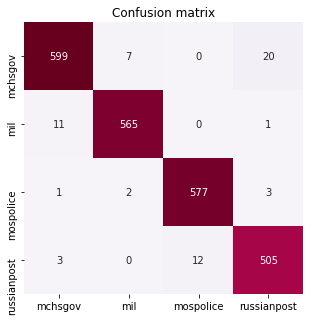

In [20]:
matrix = confusion_matrix(test.source, predictions)

plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

__После применения данного пайплайна качество модели очень высокое (accuracy = 0.974). По confusion matrix можно увидеть распределение слов по классам. Видно, самая большая ошибка (20) - это отнесение текста к почте, хотя оно относится к мчс__

## Задание 4 [2 балла]. Снижение размерности
Добавьте в ваш ```sklearn.pipeline```  методы снижения размерности:  PCA / LSI / LSA / LDA / другое. Какие методы классификации разумно использовать после снижения размерности? Как изменились результаты классификации после добавления нового шага?

__Возьмем LSI, который использует SVD (singular value decomposition) для понижения размерности. SVM является хорошим оптимальным классификатором, поэтому будем также использовать его после понижения размерности__ 

In [21]:
from sklearn.decomposition import TruncatedSVD

vectorizer = CountVectorizer() 
tfidf = TfidfTransformer()
svd = TruncatedSVD(n_components=100)
classifier = LinearSVC() 

clf_svd = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf),
    ('svd', svd),
    ('clf', classifier)
])

clf_svd.fit(train.source_text, train.source)
pred = clf_svd.predict(test['source_text'])
print(classification_report(test['source'], pred))
print("Accuracy: {0:6.3f}".format(accuracy_score(test['source'], pred)))

              precision    recall  f1-score   support

     mchsgov       0.98      0.95      0.96       626
         mil       0.98      0.97      0.98       577
   mospolice       0.98      0.98      0.98       583
 russianpost       0.93      0.96      0.95       520

    accuracy                           0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy:  0.967


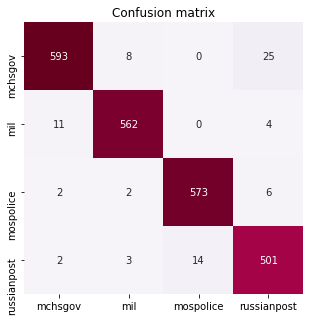

In [22]:
matrix = confusion_matrix(test['source'], pred)

plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=clf_svd.classes_,
            yticklabels=clf_svd.classes_, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

___Как видно, понижение размерности не улучшило качество модели, а даже ухудшило его (0.967 vs 0.974). Возможно, это потому, что данных итак не такое большое количество и методы понижения размерности только портят модель___

## Задание 5 [1 балл]. Лемматизация
Посмотрите, как влияет лемматизация на качество классификации. Как изменится качество классификации, если вы используете ```CountVectorizer``` на словах или $n$-граммах на лемматизированных текстах?

In [23]:
vectorizer = CountVectorizer()
tf_idf = TfidfTransformer()
classifier = LinearSVC()

clf = Pipeline([
    ('vect', vectorizer),
    ('tf-idf', tf_idf),
    ('clf', classifier)
])

clf.fit(train.lemmas_joined, train.source)
predictions = clf.predict(test['lemmas_joined'])
print(classification_report(test['source'], predictions))
print("Accuracy: {0:6.3f}".format(accuracy_score(test['source'], predictions)))

              precision    recall  f1-score   support

     mchsgov       0.97      0.96      0.97       626
         mil       0.99      0.98      0.98       577
   mospolice       0.98      0.99      0.98       583
 russianpost       0.96      0.97      0.96       520

    accuracy                           0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy:  0.974


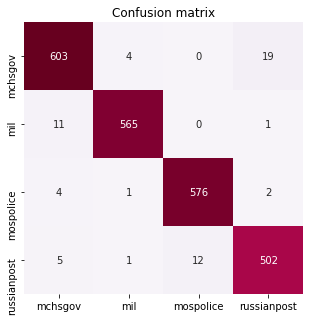

In [24]:
matrix = confusion_matrix(test.source, predictions)

plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

___Лемматизация не дала сильного улучшения модели судя по accuracy. Confusion matrix также стала лучше для одних классов, но хуже для других___

### Добавим n-gramms к лемматизированному тексту

In [25]:
vectorizer = CountVectorizer(ngram_range=(1,3))
tf_idf = TfidfTransformer()
classifier = LinearSVC()

clf = Pipeline([
    ('vect', vectorizer),
    ('tf-idf', tf_idf),
    ('clf', classifier)
])

clf.fit(train.lemmas_joined, train.source)
predictions = clf.predict(test['lemmas_joined'])
print(classification_report(test['source'], predictions))
print("Accuracy: {0:6.3f}".format(accuracy_score(test['source'], predictions)))

              precision    recall  f1-score   support

     mchsgov       0.98      0.96      0.97       626
         mil       0.99      0.98      0.98       577
   mospolice       0.98      0.99      0.98       583
 russianpost       0.96      0.97      0.96       520

    accuracy                           0.98      2306
   macro avg       0.97      0.98      0.98      2306
weighted avg       0.98      0.98      0.98      2306

Accuracy:  0.975


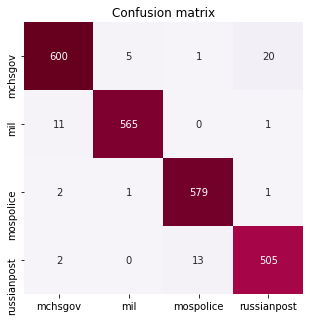

In [26]:
matrix = confusion_matrix(test.source, predictions)

plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

__Добавление n_grams увеличило немножко качество (с 0.974 до 0.975), так как мы стали смотреть не одно предыдущее слово для определения вероятности текущего, а несколько предыдущих слов, то есть больше учитывать контекст__

## Задание 6 [3 балла]. Continious bag of words
Для baseline решения мы использовали обычное представление текста в виде мешка слов. Попробуйте использовать другие модели представления текста – например, в виде непрерывного мешка слов, то есть, в виде набора эмбеддингов. Для того, чтобы получить вектор текста попробуйте:
* усреднить все эмбеддинги слов, входящих в этот текст
* усреднить все эмбеддинги слов, входящих в этот текст с $tf-idf$ весами
* использовать любую модель эмбеддинга документа.

Используйте любую модель эмбеддингов по вашему вкусу. 


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [27]:
from gensim.models import Word2Vec 

model = Word2Vec(df.lemmas, size=200, window=10, min_count=10, workers=10) 
 
def get_matrix(text, model): 
    vector = np.zeros(shape=model.vector_size) 
    counter = 0 
    for word in text.split(): 
        if word in model.wv.vocab: 
            try: 
                vector = np.add(vector, model[word]) 
                counter += 1 
            except KeyError:
                pass
    if counter == 0: 
        return vector.squeeze() 
    return (vector / counter).squeeze() 

train_vectors = [get_matrix(text, model) for text in train.lemmas_joined] 
test_vectors = [get_matrix(text, model) for text in test.lemmas_joined]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [28]:
clf = LinearSVC()
clf.fit(train_vectors, train.source)
pred = clf.predict(test_vectors)

print(classification_report(test['source'], pred))
print("Accuracy: {0:6.3f}".format(accuracy_score(test['source'], pred)))

              precision    recall  f1-score   support

     mchsgov       0.97      0.94      0.96       626
         mil       0.98      0.97      0.97       577
   mospolice       0.96      0.98      0.97       583
 russianpost       0.93      0.96      0.95       520

    accuracy                           0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306

Accuracy:  0.961


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


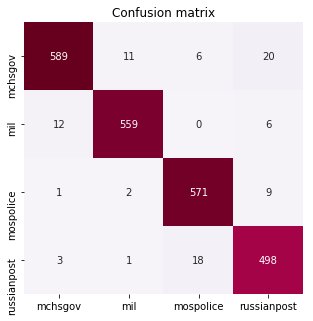

In [29]:
matrix = confusion_matrix(test.source, pred)

plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

### Добавим tf-idf

In [30]:
tf_idf = TfidfTransformer()

tf_idf_train = tf_idf.fit_transform(train_vectors)
tf_idf_test = tf_idf.fit_transform(test_vectors)

clf = LinearSVC()
clf.fit(tf_idf_train, train.source)
pred = clf.predict(tf_idf_test)
print(classification_report(test['source'], pred))
print("Accuracy: {0:6.3f}".format(accuracy_score(test['source'], pred)))

              precision    recall  f1-score   support

     mchsgov       0.96      0.93      0.95       626
         mil       0.97      0.97      0.97       577
   mospolice       0.95      0.99      0.97       583
 russianpost       0.95      0.95      0.95       520

    accuracy                           0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306

Accuracy:  0.959


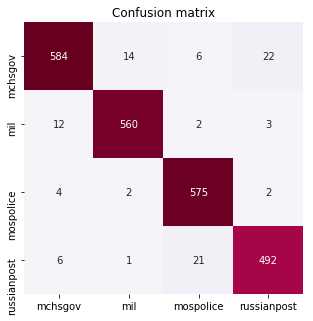

In [31]:
matrix = confusion_matrix(test.source, pred)

plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

___Continuous bag of words только ухудшил качество модели.Возможно, это связано с тем, что мы не брали предобученные эмбеддинги, а сами их сделали___

## Задание 7 [2 балла]. fastText

Используйте ```fastText``` в режиме классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [32]:
!pip install fasttext
import fasttext

In [0]:
with open('fasttext.txt', 'w', encoding = 'utf-8') as f: 
    for i in train.index: 
        text = str(train.lemmas_joined[i]) 
        tag = str(train.source[i]) 
        f.write(text + ' ' + 'label' + tag + '\n')

In [34]:
clf = fasttext.supervised('fasttext.txt', 'model', label_prefix='label')
pred = clf.predict([words for words in test.lemmas_joined])

print(classification_report(test['source'], pred))
print("Accuracy: {0:6.3f}".format(accuracy_score(test['source'], pred)))

              precision    recall  f1-score   support

     mchsgov       0.97      0.96      0.96       626
         mil       0.98      0.98      0.98       577
   mospolice       0.97      0.98      0.98       583
 russianpost       0.95      0.97      0.96       520

    accuracy                           0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy:  0.969


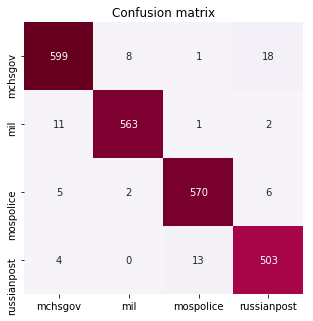

In [35]:
matrix = confusion_matrix(test.source, pred)
labels = ['mchsgov', 'mil', 'mospolice', 'russianpost']
plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

__Fast text дал сравнительно неплохой результат. Accuracy = 0.969, также по confusion matrix видно, что не так много текстов было отнесено к другим классам. Самые высокие значения - 18 и 13, которые были неправильно отнесены к почте и полиции, соответственно.__

## Задание 8 [4 балла]. CNN

Реализуйте модель Kim et al (2014) для решения задачи классификации с помощью CNN. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).
Ссылка: Kim Y. Convolutional Neural Networks for Sentence Classification. 2014

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
maxlen = 200
max_features = 6000
embed_size = 256
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train.lemmas_joined)
list_tokenized_train = tokenizer.texts_to_sequences(train.lemmas_joined)
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
list_tokenized_test = tokenizer.texts_to_sequences(test.lemmas_joined)
X_test =  pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
le = LabelEncoder()
le.fit(train.source.unique())
y_train = np_utils.to_categorical(le.transform(train.source), 4)
y_test = np_utils.to_categorical(le.transform(test.source), 4)

In [0]:
TEXT_LENGTH = 200
VOCABULARY_SIZE = 50000
MAX_FEATURES = 5000
batch_size = 100
epochs = 3

In [40]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                            embed_size,
                            input_length=TEXT_LENGTH,
                            trainable=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 8298 samples, validate on 922 samples
Epoch 1/3
8298/8298 [==============================] - 8s 904us/step - loss: 0.5927 - acc: 0.7744 - val_loss: 0.1628 - val_acc: 0.9610
Epoch 2/3
8298/8298 [==============================] - 1s 181us/step - loss: 0.0888 - acc: 0.9742 - val_loss: 0.1336 - val_acc: 0.9718
Epoch 3/3
8298/8298 [==============================] - 1s 180us/step - loss: 0.0363 - acc: 0.9908 - val_loss: 0.1456 - val_acc: 0.9664


In [0]:
predicted = model.predict_classes(X_test)
predicted = le.inverse_transform(predicted)

In [42]:
predicted = model.predict_classes(X_test)
predicted = le.inverse_transform(predicted)
y_true = le.transform(test.source)
y_true = le.inverse_transform(y_true)
print(classification_report(y_true, predicted))
print("Accuracy: {0:6.3f}".format(accuracy_score(y_true, predicted)))

              precision    recall  f1-score   support

     mchsgov       0.97      0.96      0.97       626
         mil       0.99      0.97      0.98       577
   mospolice       0.98      0.98      0.98       583
 russianpost       0.95      0.97      0.96       520

    accuracy                           0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy:  0.973


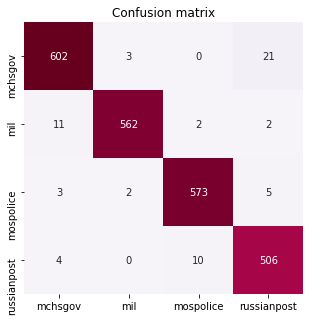

In [43]:
matrix = confusion_matrix(y_true, predicted)
labels = ['mchsgov', 'mil', 'mospolice', 'russianpost']
plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

___Модель Kim et al (2014) показала высокое качество для решения задачи классификации с помощью CNN. Accuracy = 0.973. Матрица ошибок также не показала высоких значений, то есть ошибка классификации почти что минимальная___

## Задание 9 [4 + 2 балла]. RNN

(4 балла)Используйте ```RNN``` (BLSTM с какими-то признаками и пулинг поверх) для решения задачи текстовой классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).

За дополнительные 2 балла добавьте в модель символьные признаки - CharCNN или CharRNN

In [47]:
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(96, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(4, activation="softmax"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 3
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8298 samples, validate on 922 samples
Epoch 1/3
8298/8298 [==============================] - 42s 5ms/step - loss: 0.5396 - acc: 0.8362 - val_loss: 0.1181 - val_acc: 0.9696
Epoch 2/3
8298/8298 [==============================] - 40s 5ms/step - loss: 0.0872 - acc: 0.9789 - val_loss: 0.1123 - val_acc: 0.9718
Epoch 3/3
8298/8298 [==============================] - 41s 5ms/step - loss: 0.0530 - acc: 0.9860 - val_loss: 0.1081 - val_acc: 0.9707


In [0]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

In [50]:
y_true = le.transform(test.source)
y_true = le.inverse_transform(y_true)
print(classification_report(y_true, y_pred))
print("Accuracy: {0:6.3f}".format(accuracy_score(y_true, y_pred)))

              precision    recall  f1-score   support

     mchsgov       0.97      0.95      0.96       626
         mil       0.99      0.98      0.98       577
   mospolice       0.97      0.99      0.98       583
 russianpost       0.94      0.96      0.95       520

    accuracy                           0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy:  0.968


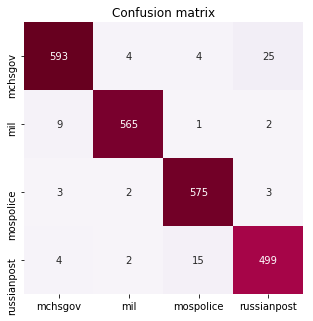

In [51]:
matrix = confusion_matrix(y_true, y_pred)
labels = ['mchsgov', 'mil', 'mospolice', 'russianpost']
plt.figure(figsize = (5,5))
sns.heatmap(data=matrix, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

## Вывод

__Bidirectional LSTM c пулингом, дропаут-регуляризацией и полносвязным слоем дало высокое качество (Accuracy = 0.968) при решении задачи текстовой классификации. Однако, качество хуже чем у CNN. Возможно, это связано с подбором гиперпараметров и можно было найти гиперпараметры для данной сети, которые показали бы лучшее качество, чем у CNN. По confusion matrix можно сказать, что больше всего сеть ошибается на классе мчс и почте, ложно относя мчс тексты к почте (25), а тексты почты к полиции(15)__